# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf

C:\Users\blacat\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [50]:
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 10)

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

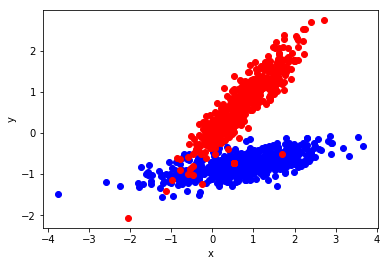

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [5]:
import random
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(random.choices(string.ascii_letters, k = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [6]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    sigmoid = 1. / ( 1. + np.exp(- X) )
    return sigmoid

def sigmoid_op_backward(op, grads):
    # TODO: реализовать вычисление градиента для sigmoid
    outs = op.outputs[0]  # тензор выходных данных после реализации оп. сигмоид
    sigmoid_back = tf.multiply(grads, tf.multiply(outs , (1. - outs)))
    return sigmoid_back

## Создание графа вычислений и обучение модели

In [53]:
learn_rate = np.array(range(1, 6))*0.5
learn_rate

array([0.5, 1. , 1.5, 2. , 2.5])

Немного поэкспериментировала, и посмотрела, как быстро сходится модель в зависимости от learning_rate (те подобрала лучший)

In [54]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения
LR_dict={} # словарь всех ошибок

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    for i in learn_rate:
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
        plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
        plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
        var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
        var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
        var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
        cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = i).minimize(cost)

    # инициализируем placeholder'ы и переменные
        sess.run(tf.global_variables_initializer())
    
        indices = np.arange(len(X))  # массив индексов объектов
        learning_curve = []
    # выполняем итерации по 10-ти эпохам
        for epoch in range(10):
        
        # вначале каждой эпохи перемешиваем индексы
            np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
            for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
                batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
                loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
                learning_curve.append(loss)
                
            # выводим текущее значение ошибки для каждого 10го шага
                steps = len(learning_curve) - 1
                if steps % 10 == 0:
                    print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
            
    # сохраняем обученные веса
        weights = var_W.eval()
        LR_dict[i] = learning_curve

[000] loss=0.753 weights=[[0.42327738 0.22303742]]
[010] loss=0.727 weights=[[ 0.28154543 -0.21833317]]
[020] loss=0.654 weights=[[ 0.15482853 -0.63917947]]
[030] loss=0.638 weights=[[ 0.07266702 -0.9891018 ]]
[040] loss=0.633 weights=[[ 0.03493917 -1.2693586 ]]
[050] loss=0.669 weights=[[ 0.02407983 -1.5063704 ]]
[060] loss=0.624 weights=[[ 0.03509953 -1.7075386 ]]
[070] loss=0.646 weights=[[ 0.03415902 -1.8861179 ]]
[080] loss=0.577 weights=[[ 0.0507043 -2.049128 ]]
[090] loss=0.628 weights=[[ 0.06179867 -2.19235   ]]
[000] loss=0.705 weights=[[0.42367372 0.17824712]]
[010] loss=0.650 weights=[[ 0.15326507 -0.6756058 ]]
[020] loss=0.617 weights=[[ 0.04052448 -1.2965862 ]]
[030] loss=0.591 weights=[[ 0.03209406 -1.7331092 ]]
[040] loss=0.564 weights=[[ 0.05847306 -2.0723503 ]]
[050] loss=0.600 weights=[[ 0.08160151 -2.3448641 ]]
[060] loss=0.602 weights=[[ 0.10025205 -2.5759327 ]]
[070] loss=0.573 weights=[[ 0.12882254 -2.773724  ]]
[080] loss=0.626 weights=[[ 0.15841988 -2.9429367 ]]

## Визуализируем кривые обучения

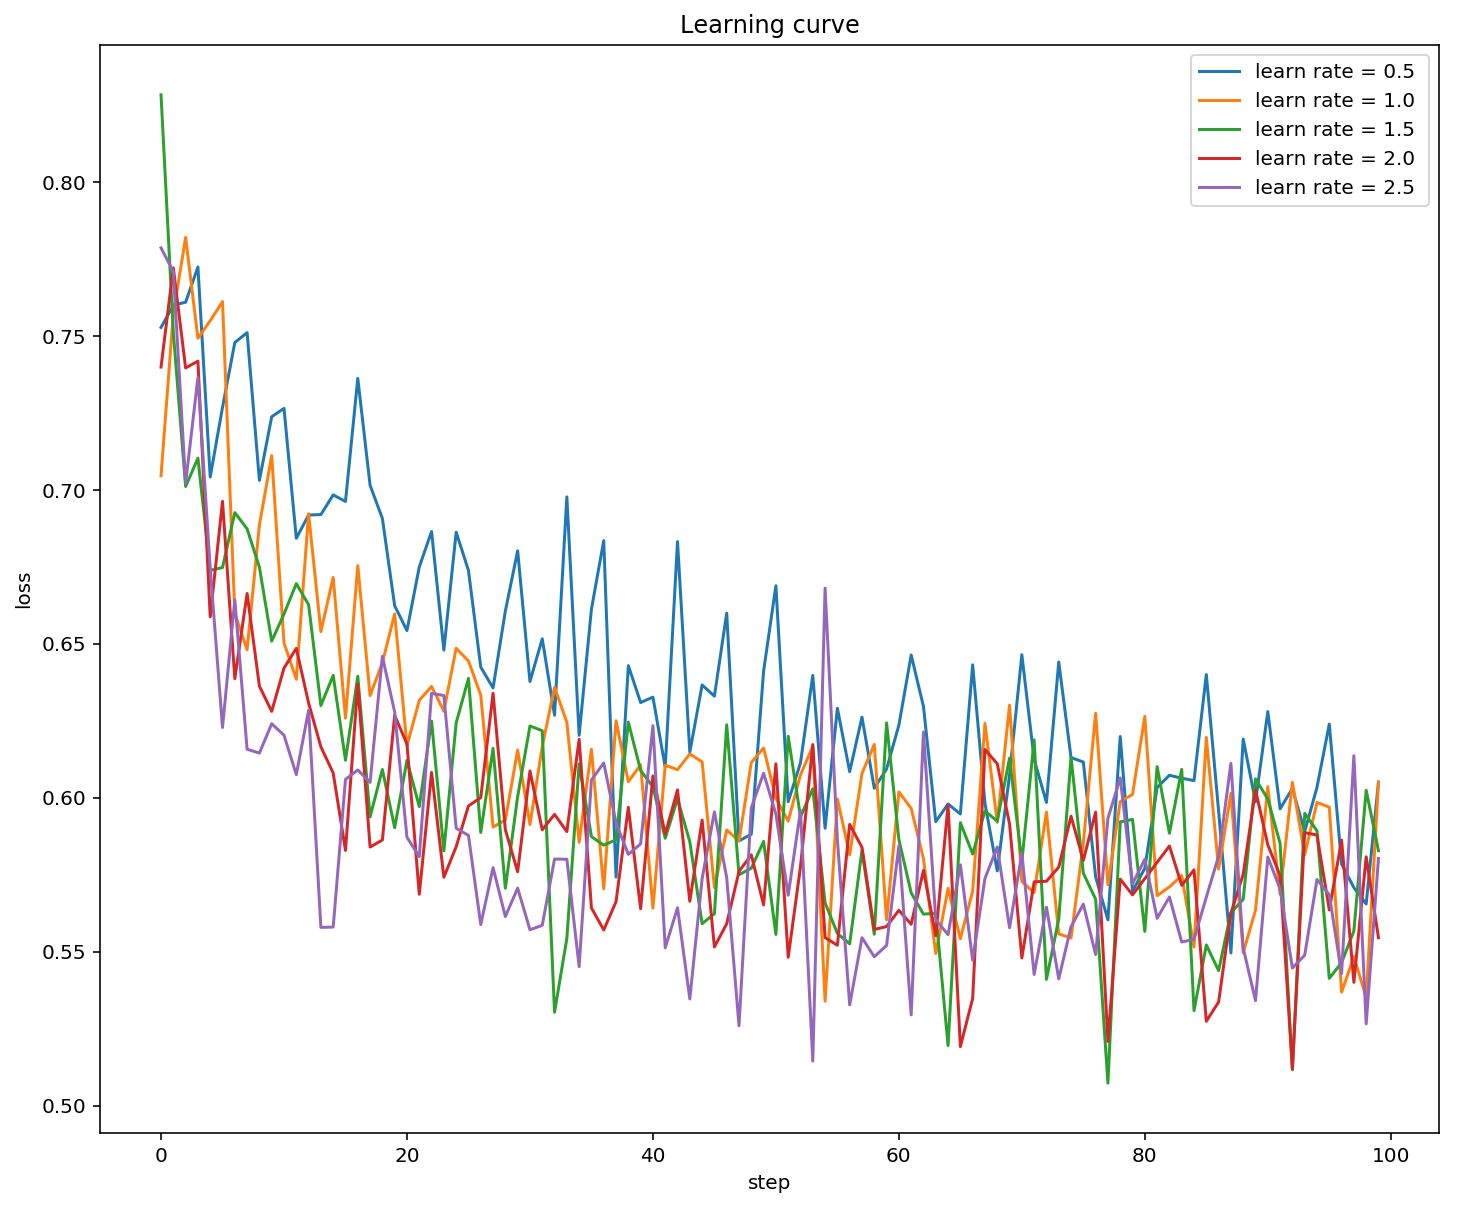

In [60]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
for j in range(len(learn_rate)):
    #print(learn_rate[j])
    plt.plot(LR_dict[learn_rate[j]],label='learn rate = {:.1f} '.format(learn_rate[j])) 
    plt.legend(loc='upper right')

Заметно, что, чем больше learning rate в нашем случае, тем быстрее сходится модель (фиолетовый цвет линии lr = 2.5)

## Визуализируем разделяющую гиперплоскость

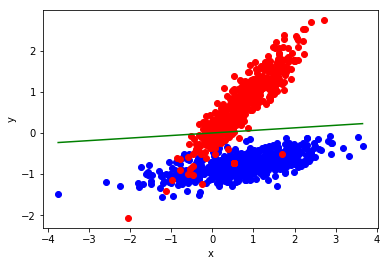

In [17]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');